# Tracking the Evolution of Irregular Satellites

Here, we initialize some randomly-distributed satellites around a planet, filling its Hill sphere, and study which ones remain stable over long timescales.

In [1]:
import rebound
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(50)

# details about star and planet
m_star = 1
m_planet = 1e-3
a_planet = 5.2
e_planet = 0.05

# defining the Hill radius
r_Hill = a_planet*(1 - e_planet) * (m_planet / (3*m_star))**(1/3)

For easy initialization (using orbital elements) we'll initialize the satellites with the planet as their main body.  For easier viewing, we treat the planet as the 'primary' particle of the entire simulation, and let the star orbit around *it*. We give the satellites a range of possible semimajor axes and inclinations, but keep them all circular.

In [3]:
# details about satellites
num_sats = 500

a_sats = np.random.uniform(.1*r_Hill, r_Hill, num_sats)    # a ranges from .1*r_Hill to r_Hill (au)
i_sats = np.random.uniform(0, np.pi, num_sats)             # i ranges from 0 to pi (radians) 
om_sats = np.random.uniform(0, 2*np.pi, num_sats)          # omega ranges from 0 to 2 pi (radians)

In [4]:
sim = rebound.Simulation()

# add planet
sim.add(m=m_planet, hash='planet')

# add satellites around planet
for i in range(num_sats):
    sim.add(m=0, a=a_sats[i], inc=i_sats[i], omega=om_sats[i], primary='planet')
    # note that we set m = 0 -- these will be test particles, so they won't interact with each other
    
# add star "orbiting" planet
sim.add(m=m_star, a=a_planet, e=e_planet, hash='star')

We're going to use the [`WHFast`](https://rebound.readthedocs.io/en/latest/ipython_examples/WHFast/) integrator, which includes the many correctors involved in the Wisdom-Holman integration scheme. We set the timestep to be $0.5 \text{ yr}$, which should handle the closest-in satellites well enough. Note that because `WHFast` uses a fixed timestep, if a satellite becomes eccentric and comes much closer in than $0.1r_{\text{Hill}}$, this integration will not handle it well. See `Exceptions.ipynb` for how to check for collisional encounters, or use [`ias15`](https://rebound.readthedocs.io/en/latest/integrators/#:~:text=in%20this%20section.-,IAS15,-IAS15%20stands%20for) for a 15th-order, adaptive timestep integrator that will handle them automatically, at the cost of some integration speed.

In [5]:
sim.integrator = 'whfast'
sim.dt = .5

We now integrate over $10^4\text{ yr}$, tracking the orbital properties of the satellites at 1000 steps evenly spaced over that integration time. Each time through the for loop in the cell below, `Rebound` integrates to a particular time, then records semimajor axis $a$, eccentricity $e$ and inclination $i$ of each moon at that time. **Note that this next cell should take ~20 seconds to run.**

In [6]:
%%time

maxTime = 1e4
steps = 1000

times = np.linspace(0., maxTime, steps)
a_data = np.zeros((steps,num_sats))
e_data = np.zeros((steps,num_sats))
i_data = np.zeros((steps,num_sats))

for i, time in enumerate(times):
    sim.integrate(time)

    for moon in range(num_sats):
        a_data[i,moon] = sim.particles[moon + 1].a
        e_data[i,moon] = sim.particles[moon + 1].e
        i_data[i,moon] = sim.particles[moon + 1].inc

i_data = i_data * (180/np.pi)     # convert inclination data from radians to degrees

CPU times: user 21.9 s, sys: 69.7 ms, total: 21.9 s
Wall time: 21.9 s


We can now plot the changes in semimajor axis, eccentricity, and inclination of any satellite over time. An example of this is shown below.

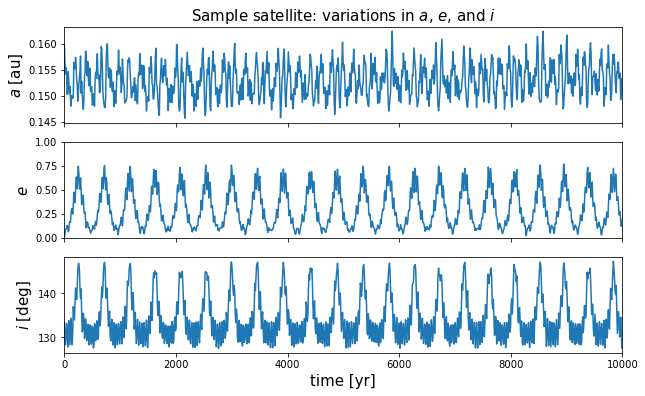

In [7]:
fig, ax = plt.subplots(3,figsize=(10,6),sharex=True)
ax[0].set_title(r'Sample satellite: variations in $a$, $e$, and $i$',fontsize=15)

sat_idx = 130

# semi-major axis plot
ax[0].plot(times,a_data[:,sat_idx])
ax[0].set_ylabel(r'$a$ [au]',fontsize=15)

# eccentricity plot
ax[1].plot(times,e_data[:,sat_idx])
ax[1].set_ylabel(r'$e$',fontsize=15)
ax[1].set_ylim(0,1)

# inclination plot
ax[2].plot(times,i_data[:,sat_idx])
ax[2].set_ylabel(r'$i$ [deg]',fontsize=15)
ax[2].set_xlabel('time [yr]',fontsize=15)
ax[2].set_xlim(0,times[-1])

plt.show()

This particular satellite begins with $i \sim 130^\circ$. At such a high inclination, [von Zeipel-Lidov-Kozai](https://en.wikipedia.org/wiki/Kozai_mechanism) (ZKL) effects will come into play, exciting an eccentricity and leading to oscillations between $e$ and $i$, as observed. In some cases, $e$ will be excited to close to $1$, leading to the satellite colliding with the planet. The setup in this notebook doesn't handle these collisions, but see `EccentricComets.ipynb` or `CloseEncounters.ipynb` for examples of how to deal with these situations.

If we plot the evolution of $a$ for all satellites,

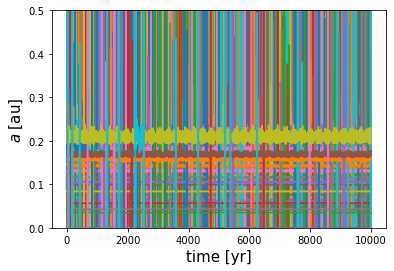

In [8]:
plt.plot(times,a_data)
plt.ylabel(r'$a$ [au]',fontsize=15)
plt.xlabel('time [yr]',fontsize=15)
plt.ylim(0,.5)
plt.show()

we see that some of them clearly become unstable! We now might want to plot the initial conditions of these satellites and color code by whether they went unstable or not to see if any sort of pattern emerges. 

Since the orbital elements of these satellites refer to their orbit around the planet, they become nonsensical if the satellite leaves the planet's sphere of influence and begins orbiting the star instead (as seen in the plot above). We can use this to set a criterion for instability: if the satellite has a semimajor axis $a<0$ (non-physical) at any point, it went unstable. 

This is a good start, but not all satellites that go unstable necessarily will take on a non-physical $a$, so we also want to check for satellites that take on $a > r_{\text{Hill}}$ at any point.

In [9]:
# creating boolean for each satellite representing whether it becomes unstable
sat_unstable = [(min(a_data[:,s]) < 0) or (max(a_data[:,s]) > r_Hill) for s in range(0,num_sats)]

# creating boolean for each satellite representing whether it has r_p < r_planet
sat_collision = [(0 < min(a_data[:,s]*(1-e_data[:,s])) < 0.00048) for s in range(0,num_sats)]

We also created a check for whether or not a satellite ever had a pericenter distance $r_p \equiv a(1-e)$ smaller than an arbitrary planet radius (which we set as Jupiter's radius). These would theoretically collide with the planet. Of course, because we are using `WHFast`, such close encounters are not well-integrated, and the `Rebound` orbits of bodies that come this close probably aren't reliable after such a passage. 

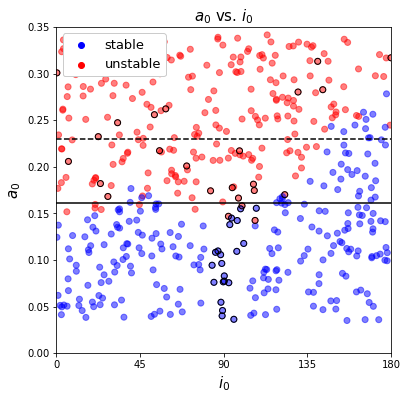

In [10]:
# plotting stability in the context of initial a vs i
fig, ax = plt.subplots(figsize=(6,6))
colours = ['red' if u else 'blue' for u in sat_unstable]

plt.scatter(i_sats*(180/np.pi),a_sats,c=colours,alpha=.5)
plt.scatter(i_sats[sat_collision]*(180/np.pi),a_sats[sat_collision],edgecolor='k',facecolors='none')

plt.hlines(r_Hill*.47,0,180,color='k')
plt.hlines(r_Hill*.67,0,180,color='k',ls='--')


plt.ylabel(r'$a_0$',fontsize=15)
plt.xlabel(r'$i_0$',fontsize=15)

plt.xlim(0,180)
plt.xticks([0,45,90,135,180])
plt.ylim(0,.35)
plt.title(r'$a_0$ vs. $i_0$',fontsize=15)

s = plt.scatter(np.nan,np.nan,color='blue')
u = plt.scatter(np.nan,np.nan,color='red')
plt.legend(handles=[s,u],labels=['stable','unstable'],fontsize=13,framealpha=1,loc='upper left')

plt.show()

Here we have plotted a solid black line at $0.47r_{\text{Hill}}$. This is a rough estimate for the stability boundary for prograde ($i<90^\circ$) orbits, and we can see that it traces the stable-unstable boundary from our simulations well. We have also plotted a dashed black line at $0.67r_{\text{Hill}}$, which is a rough boundary for stability of retrograde orbits ($i>90^\circ$). We can see that these (especially those with $i>135^\circ$) seem to be more stable than prograde orbits at higher $a_0$. This known effect can be thought of intuitively in a frame corotating with the planet; there, the Coriolis acceleration for a prograde orbit points away from the planet, but the acceleration for a retrograde orbit points toward the planet. [Nesvorný et al. (2003)](https://iopscience.iop.org/article/10.1086/375461/fulltext/202528.text.html) give an in depth discussion on the orbital evolution of irregular satellites.

We indicate orbits that have $r_p$ smaller than the planet's radius with black rings around datapoints. Again, these aren't a perfect census of satellites that would collide with the planet due to integration issues, but we can already see that polar ($i\sim 90^\circ$) orbits seem to be the most likely culprits for collisions, likely due to ZKL oscillations.

Below, we show the same data in a polar plot, with $a_0$ and $i_0$ providing the radial and angular coordinates, respectively.

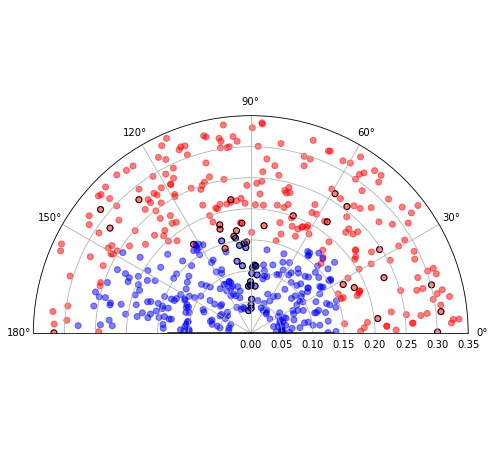

In [11]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(8,8))

colours = ['red' if u else 'blue' for u in sat_unstable]

plt.scatter(i_sats,a_sats,c=colours,alpha=.5)
plt.scatter(i_sats[sat_collision],a_sats[sat_collision],edgecolor='k',facecolors='none')
plt.plot([0,np.pi],np.full(2,r_Hill*.39),color='k')

plt.xlim(0,np.pi)
plt.ylim(0,.35)

plt.show()